In [48]:
import numpy as np
import cProfile
from numba import njit, jit
import matplotlib.pyplot as plt
%matplotlib inline

## N-Body problems

Many physical problems require the evaluation of all pairwise interactions of a large number of particles, so-called N-body problems. These problems arise in molecular dynamics, astrodynamics and electromagnetics among others. 

Their pairwise interactions can be expressed as:

\begin{equation}
f_i = \sum_{j=1}^n{P \left(\boldsymbol{x}_i, \boldsymbol{x}_j \right)w_j} \ \ \ \text{for } i=1,2,...,n 
\end{equation}

*  where subscripts $i$,  $j$ respectively denote *target* and *source*
*  $f_i$ can be a *potential* (or *force*) at target point $i$
*  $w_j$ is the *source weight* 
*  $\boldsymbol{x}_i, \boldsymbol{x}_j$ are the *spatial positions* of particles 
*  $P \left(\boldsymbol{x}_i, \boldsymbol{x}_j \right)$ is the *interaction kernel*. 

In order to evalute the potential $f_i$ at a target point $i$, we have to loop over each source particle $j$. Since there are $n$ target points $i$, this 'brute-force' approach costs $\mathcal{O} \left(n^2 \right)$ operations. 

One possible approach in this kind of problem is to define a few classes, say `Point` and `Particle` and then loop over the objects and perform the necessary point-to-point calculations.

In [49]:
class Point():
    """    
    Arguments:
        domain: the domain of random generated coordinates x,y,z, 
                default=1.0
    
    Attributes:
        x, y, z: coordinates of the point
    """
    def __init__(self, domain=1.0):
        self.x = domain * numpy.random.random()
        self.y = domain * numpy.random.random()
        self.z = domain * numpy.random.random()
            
    def distance(self, other):
        return ((self.x - other.x)**2 + 
                (self.y - other.y)**2 + 
                (self.z - other.z)**2)**.5

In [50]:
class Particle(Point):
    """    
    Attributes:
        m: mass of the particle
        phi: the potential of the particle
    """
    
    def __init__(self, domain=1.0, m=1.0):
        Point.__init__(self, domain)
        self.m = m
        self.phi = 0.

Now we create a list of `n` random particles, define a function to calculate their interaction via direct summation and run!

In [51]:
n = 1000
particles = [Particle(m = 1 / n) for i in range(n)]

In [52]:
def direct_sum(particles):
    """
    Calculate the potential at each particle
    using direct summation method.

    Arguments:
        particles: the list of particles

    """
    for i, target in enumerate(particles):
        for source in (particles[:i] + particles[i+1:]):
            r = target.distance(source)
            target.phi += source.m / r

In [53]:
direct_sum(particles)

In [54]:
orig_time = %timeit -o direct_sum(particles)

516 ms ± 3.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [55]:
%load_ext line_profiler

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


In [56]:
%lprun -f direct_sum direct_sum(particles)

## How do we use Numba on this problem?
Problem: Numba doesn't support jitting native Python classes.  There is a `jit_class` structure in Numba but it's still in early development.

But it's nice to have attributes for literate programming.

Solution: NumPy custom dtypes.

In [57]:
particle_dtype = numpy.dtype({'names':['x','y','z','m','phi'], 
                             'formats':[numpy.double, 
                                        numpy.double, 
                                        numpy.double, 
                                        numpy.double, 
                                        numpy.double]})

In [58]:
myarray = numpy.ones(3, dtype=particle_dtype)

In [59]:
myarray

array([(1., 1., 1., 1., 1.), (1., 1., 1., 1., 1.), (1., 1., 1., 1., 1.)],
      dtype=[('x', '<f8'), ('y', '<f8'), ('z', '<f8'), ('m', '<f8'), ('phi', '<f8')])

In [60]:
myarray[0]['x'] = 2.0

In [61]:
myarray

array([(2., 1., 1., 1., 1.), (1., 1., 1., 1., 1.), (1., 1., 1., 1., 1.)],
      dtype=[('x', '<f8'), ('y', '<f8'), ('z', '<f8'), ('m', '<f8'), ('phi', '<f8')])

### Exercise 1

Write a function `create_n_random_particles` that takes the arguments `n` (number of particles), `m` (mass of every particle) and a domain within to generate a random number (as in the class above).
It should create an array with `n` elements and `dtype=particle_dtype` and then return that array.

For each particle, the mass should be initialized to the value of `m` and the potential `phi` initialized to zero.

For the `x` component of a given particle `p`, you might do something like

```python
p['x'] = domain * numpy.random.random()
```

In [62]:
@njit
def create_n_random_particles(n, m, domain=1):
    '''
    Creates `n` particles with mass `m` with random coordinates
    between 0 and `domain`
    '''
    parts = numpy.zeros((n), dtype=particle_dtype)


    ### your code
    ### your code
    ### your code
    for i in range(n):
        parts[i]['x'] = domain * np.random.random()
        parts[i]['y'] = domain * np.random.random()
        parts[i]['z'] = domain * np.random.random()
        parts[i]['m'] = m    
    
    return parts   #parts is an array of particles

In [63]:
# test it
parts = create_n_random_particles(1000, .001, 1)

### Exercise 2

Write a JITted function `distance` to calculate the distance between two particles of dtype `particle_dtype`

Here's the `distance` method from the `Particle` class as a reference:

```python
def distance(self, other):
        return ((self.x - other.x)**2 + 
                (self.y - other.y)**2 + 
                (self.z - other.z)**2)**.5
```

In [64]:

def distance(part1, part2):
    '''calculate the distance between two particles'''
    return ((part1['x'] - part2['x'])**2 + 
            (part1['y'] - part2['y'])**2 + 
            (part1['z'] - part2['z'])**2)**.5

@njit
def distance_jit(part1, part2):
    '''calculate the distance between two particles'''
    return ((part1['x'] - part2['x'])**2 + 
            (part1['y'] - part2['y'])**2 + 
            (part1['z'] - part2['z'])**2)**.5


In [65]:
# test it

distance(parts[0], parts[1])

0.48354217761774365

### Exercise 3
Modify the original `direct_sum` function (copied below for reference) to instead work a NumPy array of particles.  Loop over each element in the array and calculate its total potential.

```python
def direct_sum(particles):
    """
    Calculate the potential at each particle
    using direct summation method.

    Arguments:
        particles: the list of particles

    """
    for i, target in enumerate(particles):
        for source in (particles[:i] + particles[i+1:]):
            r = target.distance(source)
            target.phi += source.m / r

In [66]:
def direct_sum(particles):
    # take it away
    for i, target in enumerate(particles):
        
        '''
        for j in np.arange(0, len(particles)):
            if i == target: continue 
            source = particles[j]
            r = distance(target, source)
            target['phi'] += source['m'] / r
        '''
        for j in np.arange(0, i):
            source = particles[j]
            r = distance(target, source)
            target['phi'] += source['m'] / r
            
        for j in np.arange(i + 1, len(particles)):
            source = particles[j]
            r = distance(target, source)
            target['phi'] += source['m'] / r
            
@jit
def direct_sum_jit(particles):
    # take it away
    for i, target in enumerate(particles):

        '''
        for j in np.arange(0, len(particles)):
            if i == target: continue 
            source = particles[j]
            r = distance(target, source)
            target['phi'] += source['m'] / r
        '''
        for j in np.arange(0, i):
            source = particles[j]
            r = distance_jit(target, source)
            target['phi'] += source['m'] / r
            
        for j in np.arange(i + 1, len(particles)):
            source = particles[j]
            r = distance_jit(target, source)
            target['phi'] += source['m'] / r

In [72]:
import time
time_numpy = []
time_jit = []
start_time = 0
Range = range(500, 1000, 200)
for size in Range:
    parts = create_n_random_particles(size, .001, 1)
    
    start_time = time.time()
    direct_sum(parts)
    time_numpy.append(time.time() - start_time)

    start_time = time.time()
    direct_sum_jit(parts)
    time_jit.append(time.time() - start_time)

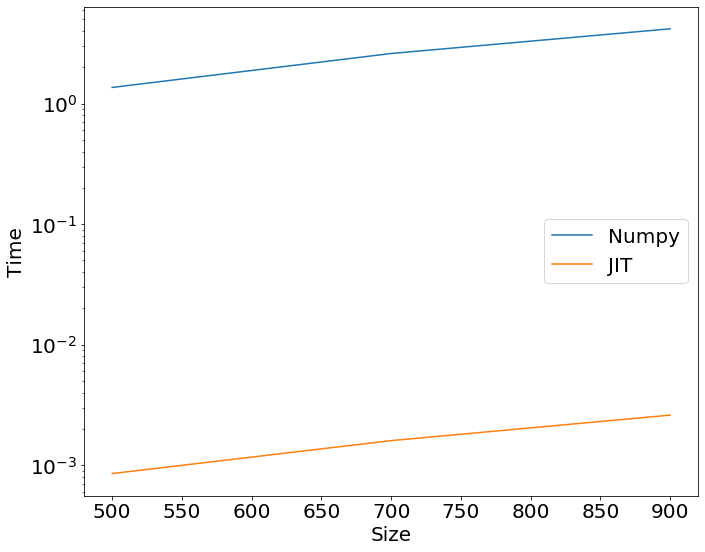

In [74]:
plt.figure(figsize=(11, 9))
plt.rcParams.update({'font.size': 20})
plt.plot(list(Range), time_numpy, label='Numpy')
plt.plot(list(Range), time_jit, label='JIT')
plt.legend(loc='best')
plt.xlabel('Size')
plt.ylabel('Time')
plt.yscale('log')
plt.show()